In [446]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [447]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Inicializar una partícula
        self.r = r0
        self.v = v0
        self.a = a0 

        self.m = m
        self.radius = radius
        self.Id = Id

        self.p = self.m*self.v
        self.lz= np.cross(self.r,self.p)
        self.f = self.m*self.a
        self.ek= 0.5*self.m*np.dot(self.v,self.v)
   
                          
        
        # Guardar el historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)

        self.F = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
        self.Lz=  np.zeros(len(t))


        #coeficiente de compresibilidad
        self.K = 20.
        
        #Energía cinética
        self.VEk = np.zeros(len(t))
        self.Ep = 0.
        self.Up= np.zeros(len(t))
        
    def Evolution(self,i):
        
        #vEolucionar es actualizar la posición, la velocidad y la aceleración

        #TODO:quí utilizamos el método de Euler-Cromer 
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a

        self.SetPotentialEnergy(i)
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        self.p = self.m*self.v
        self.lz = np.cross(self.r,self.p)
        self.ek = 0.5*self.m*np.dot(self.v,self.v)

        
        
    def CalculateForce(self,p):


        #TODO: Aqui se calcula la fuerza y la energía potencial 
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:

                
            Fn = self.K * compresion**3
            Up= (self.K * compresion**4)/4
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            self.Ep += Up
           
            
     
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.

        #Reiniciar la dinámica del sistema se ponen en 0´s la fuerza y la aceleración
    
    #TODO: Setter (Se guarda el historial)
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.Lz[i]= np.cross(self.r,(self.m*self.v))
         
 

    def SetPotentialEnergy(self,i):
        self.Up[i] = self.Ep
    
    # TODO: Getter (Obtenemos las variables de interés con el paso deseado)
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
                return self.P[::scale]

    def GetAngularMomentum(self,scale=1):
                return self.Lz[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 

    def GetPotentialEnergy(self,scale=1):
        return self.Up[::scale] 
    
    # TODO: Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]

In [448]:

#TODO: Aqui se crean las particulas 
def GetParticles(N,t):

    Particles=[]

    for i in range(N):
        r = np.random.uniform(-20, 20, size=(2,))
        v = np.random.uniform(-5, 5, size=(2,))
        a = np.array([0.,0.])
        p = Particle(r,v,a,t,m=1,radius=2,Id=0)
        

        Particles.append(p)   
    return Particles

In [449]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [450]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
        
            
    return Particles



In [451]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:49<00:00, 202.78 Steps/s]


In [452]:
scale = 200
t1 = t[::scale]

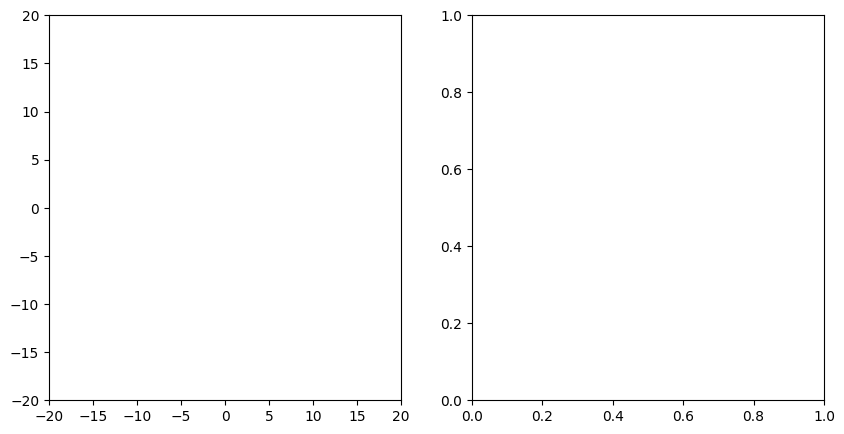

In [453]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for j, p in enumerate(Particles):
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=True )
        ax.add_patch(circle)
        
       # ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [454]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=10, metadata=dict(artist='Me'))
#Animation.save('EsferaDura.mp4', writer=writer_)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [455]:
MomentumT = Particles[0].GetMomentum(scale)

AngularMomentumT = Particles[0].GetAngularMomentum(scale)

EnergyT = Particles[0].GetKineticEnergy(scale)

EnergyP = Particles[0].GetPotentialEnergy(scale)


In [456]:
EnergyP *=0.5

In [457]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
    AngularMomentumT = np.add(AngularMomentumT,Particles[i].GetAngularMomentum(scale))
    EnergyT = np.add(EnergyT,Particles[i].GetKineticEnergy(scale))
    EnergyP = np.add(EnergyP,Particles[i].GetPotentialEnergy(scale))

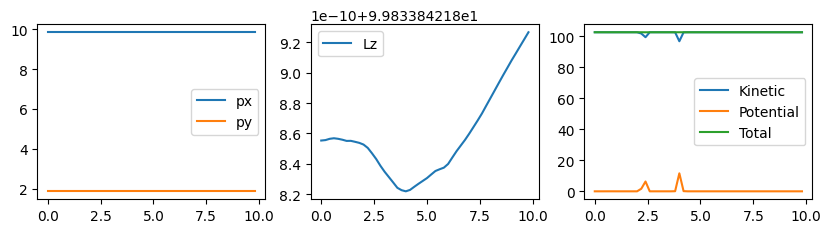

In [458]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(231)
ax4 = fig3.add_subplot(232)
ax5 = fig3.add_subplot(233)

ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax4.plot(t1,AngularMomentumT,label='Lz')
ax5.plot(t1,EnergyT,label='Kinetic')
ax5.plot(t1,EnergyP,label='Potential')
ax5.plot(t1,EnergyT+0.5*EnergyP,label='Total')
ax3.legend()
ax4.legend()
ax5.legend()

plt.show()